In [1]:
import matplotlib.pyplot as plt
import numpy as np
from astropy.io import fits
from glob import glob
import os
from astropy.visualization import (ZScaleInterval, ImageNormalize, LogStretch, 
            ManualInterval, SqrtStretch, AsymmetricPercentileInterval)
import h5py 
from astropy.nddata import CCDData
import astropy.constants as const
from astropy.wcs import FITSFixedWarning
import warnings
warnings.simplefilter("ignore", category=FITSFixedWarning)
from PIL import Image
from datetime import datetime, timedelta
from ccdproc import ImageFileCollection
import pandas as pd
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
from matplotlib.ticker import AutoLocator, AutoMinorLocator, FixedLocator, FixedFormatter, LogLocator, StrMethodFormatter
from matplotlib import patches
from matplotlib.markers import MarkerStyle
import cmcrameri.cm as cmcm
import cmasher as cmr
from scipy import ndimage
from scipy.io import readsav
import copy
from juanfit import SpectrumFitSingle, SpectrumFitRow, gaussian
from astropy.convolution import Gaussian2DKernel, interpolate_replace_nans
import astropy.units as u
import eispac

In [2]:
green_path = "../../src/EclipseSpectra2017/MikesData_l1/Green/"
red_path = "../../src/EclipseSpectra2017/MikesData_l1/Red/"

totality_green_im_collection = ImageFileCollection(green_path,
                        glob_include="TotalitySequence*.fit")
totality_green_df = totality_green_im_collection.summary.to_pandas()
totality_green_df["date-obs"] = pd.to_datetime(totality_green_df["date-obs"])

totality_green_df_cut = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,46,38)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_green_df_cut.sort_values(by="date-obs")
totality_green_df_cut = totality_green_df_cut.reset_index(drop=True)

totality_green_df_ext = totality_green_df.loc[(totality_green_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_green_df['date-obs'] < datetime(2017,8,21,17,47,8))]
totality_green_df_ext.sort_values(by="date-obs")                                        
totality_green_df_ext = totality_green_df_ext.reset_index(drop=True)

totality_red_im_collection = ImageFileCollection(red_path,
                        glob_include="TotalitySequence*.fit")
totality_red_df = totality_red_im_collection.summary.to_pandas()
totality_red_df["date-obs"] = pd.to_datetime(totality_red_df["date-obs"])

totality_red_df_cut = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,46,40)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,0))]
totality_red_df_cut.sort_values(by="date-obs")
totality_red_df_cut = totality_red_df_cut.reset_index(drop=True)

totality_red_df_ext = totality_red_df.loc[(totality_red_df['date-obs'] >= datetime(2017,8,21,17,45,36)) & 
                                        (totality_red_df['date-obs'] < datetime(2017,8,21,17,47,2))]
totality_red_df_ext.sort_values(by="date-obs")
totality_red_df_ext = totality_red_df_ext.reset_index(drop=True)

In [3]:
FeXI_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXILine_ContRatio.fits",unit="adu")
FeXI_line_cont_image = FeXI_line_cont_frame.data
sun_center_FeXI = (np.float64(FeXI_line_cont_frame.header["SUNX"]),np.float64(FeXI_line_cont_frame.header["SUNY"]))
FeXI_line_cont_xslice = slice(372-300,372+301)
FeXI_line_cont_yslice = slice(383-220,383+221)
FeXI_line_cont_cutout = FeXI_line_cont_image[FeXI_line_cont_yslice, FeXI_line_cont_xslice]
FeXI_rotate_center = (sun_center_FeXI[0] - FeXI_line_cont_xslice.start, sun_center_FeXI[1] - FeXI_line_cont_yslice.start)
FeXI_line_cont_image_rot_scipy = ndimage.rotate(FeXI_line_cont_cutout, angle=360 - np.float64(FeXI_line_cont_frame.header["SUNROT"]),reshape=False,order=1)
img_center_offset = np.array([sun_center_FeXI[0]-372, sun_center_FeXI[1]-384])
img_center_offset_rot = np.array([img_center_offset[0]*np.cos(np.deg2rad(np.float64(360-np.float64(FeXI_line_cont_frame.header["SUNROT"])))) - \
                                  img_center_offset[1]*np.sin(np.deg2rad(np.float64(360-np.float64(FeXI_line_cont_frame.header["SUNROT"])))), 
                                  img_center_offset[0]*np.sin(np.deg2rad(np.float64(360-np.float64(FeXI_line_cont_frame.header["SUNROT"])))) + \
                                    img_center_offset[1]*np.cos(np.deg2rad(np.float64(360-np.float64(FeXI_line_cont_frame.header["SUNROT"]))))])


FeXIV_line_cont_frame = CCDData.read("../../src/EclipseSpectra2017/MitchellData/MitchellFeXIVLine_ContRatio.fits",unit="adu")
FeXIV_line_cont_image = FeXIV_line_cont_frame.data
sun_center_FeXIV = (np.float64(FeXIV_line_cont_frame.header["SUNX"]),np.float64(FeXIV_line_cont_frame.header["SUNY"]))
FeXIV_line_cont_xslice = slice(372-300,372+301)
FeXIV_line_cont_yslice = slice(383-220,383+221)
FeXIV_line_cont_cutout = FeXIV_line_cont_image[FeXIV_line_cont_yslice, FeXIV_line_cont_xslice]
FeXIV_rotate_center = (sun_center_FeXIV[0] - FeXIV_line_cont_xslice.start, sun_center_FeXIV[1] - FeXIV_line_cont_yslice.start)
FeXIV_line_cont_image_rot_scipy = ndimage.rotate(FeXIV_line_cont_cutout, angle=360 - np.float64(FeXIV_line_cont_frame.header["SUNROT"]),reshape=False,order=1)

In [4]:
with h5py.File("../../sav/Eclipse/LimbTrack/sun_pos_linear_fit.h5", 'r') as hf:
    sun_x_fitparam = hf['sun_x_fitparam'][:]
    sun_y_fitparam = hf['sun_y_fitparam'][:]

sun_x_fitpoly = np.poly1d(sun_x_fitparam)
sun_y_fitpoly = np.poly1d(sun_y_fitparam)

In [5]:
slit_pos = 209.4
rsun_arcsec = 950.0
rsun_context_pixel = 71.4
pixel_ratio = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])
img_pixel_to_arcsec = np.float64(FeXI_line_cont_frame.header["SUNR"])/rsun_arcsec
pixel_ratio_to_arcsec = rsun_context_pixel/np.float64(FeXI_line_cont_frame.header["MOONR"])*img_pixel_to_arcsec
rotate_angle_context = -27.5

eis_idl_sav = readsav("../../sav/EIS/EQSPY/EQSPY_lvl1_offset_170821_tilt_cor.sav",verbose=False)
eis_eqs_xcen, eis_eqs_ycen = np.array((eis_idl_sav["xcen"], eis_idl_sav["ycen_195"])) + eis_idl_sav["xy_correct_aia"]
eis_eqs_fovx, eis_eqs_fovy = np.array((eis_idl_sav["fovx"], eis_idl_sav["fovy"]))
eis_eqs_xstart = eis_eqs_xcen - eis_eqs_fovx/2.
eis_eqs_xend = eis_eqs_xcen + eis_eqs_fovx/2.
eis_eqs_ystart = eis_eqs_ycen - eis_eqs_fovy/2.
eis_eqs_yend = eis_eqs_ycen + eis_eqs_fovy/2.

In [6]:
eis_atlas_30_fex_filename = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_10_184_536.1c-0.fit.h5"
eis_atlas_30_fexiv_filename = "../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_14_264_787.1c-0.fit.h5"
eis_ch_fex_filename = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5"
eis_ch_fexiv_filename = "../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_14_264_787.1c-0.fit.h5"

In [7]:
eis_atlas_30_shiftx, eis_atlas_30_shifty = 4.5*u.arcsec, -4*u.arcsec
eis_ch_shiftx, eis_ch_shifty = -4.096*u.arcsec, -2.505*u.arcsec

eis_atlas_30_fex_fitres =  eispac.read_fit(eis_atlas_30_fex_filename)
eis_atlas_30_fex_intmap = eis_atlas_30_fex_fitres.get_map(component=0, measurement='intensity')
eis_atlas_30_fex_intmap_shifted = eis_atlas_30_fex_intmap.shift(eis_atlas_30_shiftx, eis_atlas_30_shifty)

eis_atlas_30_fexiv_fitres =  eispac.read_fit(eis_atlas_30_fexiv_filename)
eis_atlas_30_fexiv_intmap = eis_atlas_30_fexiv_fitres.get_map(component=0, measurement='intensity')
eis_atlas_30_fexiv_intmap_shifted = eis_atlas_30_fexiv_intmap.shift(eis_atlas_30_shiftx, eis_atlas_30_shifty)

eis_ch_fex_fitres =  eispac.read_fit(eis_ch_fex_filename)
eis_ch_fex_intmap = eis_ch_fex_fitres.get_map(component=0, measurement='intensity')
eis_ch_fex_intmap_shifted = eis_ch_fex_intmap.shift(eis_ch_shiftx, eis_ch_shifty)

eis_ch_fexiv_fitres =  eispac.read_fit(eis_ch_fexiv_filename)
eis_ch_fexiv_intmap = eis_ch_fexiv_fitres.get_map(component=0, measurement='intensity')
eis_ch_fexiv_intmap_shifted = eis_ch_fexiv_intmap.shift(eis_ch_shiftx, eis_ch_shifty)

Reading fit result from, 
   ../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_10_184_536.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../sav/EIS/EQSPY/eispac_fit/eis_20170821_205401.fe_14_264_787.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_10_184_536.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]
Reading fit result from, 
   ../../sav/EIS/NPCHDB/eispac_fit/eis_20170821_110818.fe_14_264_787.1c-0.fit.h5


INFO:astropy:uncertainty should have attribute uncertainty_type.


INFO: uncertainty should have attribute uncertainty_type. [astropy.nddata.nddata]


In [8]:
img_center = np.array([300,220]) + img_center_offset_rot

def func_img_xpixel_to_xarcsec(x):
    return (x - img_center[0])/img_pixel_to_arcsec

def func_img_xarcsec_to_xpixel(x):
    return x*img_pixel_to_arcsec + img_center[0]

def func_img_ypixel_to_yarcsec(x):
    return (x - img_center[1])/img_pixel_to_arcsec

def func_img_yarcsec_to_ypixel(x):
    return x*img_pixel_to_arcsec + img_center[1]

def plot_colorbar(im, ax, width="3%", height="100%",loc="lower left",fontsize=14,
                  bbox_to_anchor=(1.02, 0., 1, 1)):
    clb_ax = inset_axes(ax,width=width,height=height,loc=loc,
                bbox_to_anchor=bbox_to_anchor,
                 bbox_transform=ax.transAxes,
                 borderpad=0)
    clb = plt.colorbar(im,pad = 0.05,orientation='vertical',ax=ax,cax=clb_ax)
    clb_ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    clb_ax.yaxis.get_offset_text().set_fontsize(fontsize)
    clb_ax.tick_params(labelsize=fontsize)
    return clb, clb_ax

def plot_eis_fov(ax,eis_map,color="red",alpha=0.7,label="EIS",zorder=2):
    eis_xstart = eis_map.bottom_left_coord.Tx.value
    eis_ystart = eis_map.bottom_left_coord.Ty.value
    eis_fovx = eis_map.dimensions.x * eis_map.scale.axis1
    eis_fovy = eis_map.dimensions.y * eis_map.scale.axis2
    rectangle = patches.Rectangle((eis_xstart, eis_ystart),
                            eis_fovx.value, eis_fovy.value,linewidth=0,edgecolor=color,
                            facecolor=color,alpha=alpha,label=label,zorder=zorder)
    ax.add_patch(rectangle)

def plot_comp_fov(ax,radii=[1.06,1.35],n=100,color="#A5DEE4",alpha=0.4,zorder=0,label=None):
    radii = np.array(radii)*rsun_arcsec
    theta = np.linspace(0, 2*np.pi, n, endpoint=True)
    xs = np.outer(radii, np.cos(theta))
    ys = np.outer(radii, np.sin(theta))

    xs[1,:] = xs[1,::-1]
    ys[1,:] = ys[1,::-1]

    ax.fill(np.ravel(xs), np.ravel(ys), facecolor=color, edgecolor=None,
             zorder=zorder,alpha=alpha,label=label)

In [9]:
green_limb_loc = np.array([396.,625.,])
x_1d_grid_green_ext = np.arange(-63,125,1,dtype=np.float64)
y_1d_grid_green_ext = np.arange(np.mean(green_limb_loc) - 699.,  np.mean(green_limb_loc) - 349., 1, dtype=np.float64)

y_1d_grid_green_arcsec_ext = y_1d_grid_green_ext/(np.diff(green_limb_loc)/2.)*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
x_1d_grid_green_arcsec_ext = x_1d_grid_green_ext * (sun_x_fitpoly(10) - sun_x_fitpoly(9.5))/pixel_ratio_to_arcsec
y_1d_grid_green_arcsec_bin_ext = np.average(y_1d_grid_green_arcsec_ext.reshape(-1,5),axis=1)

x_2d_grid_green_arcsec_ext, y_2d_grid_green_arcsec_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_ext)
x_2d_grid_green_arcsec_bin_ext, y_2d_grid_green_arcsec_bin_ext = np.meshgrid(x_1d_grid_green_arcsec_ext, y_1d_grid_green_arcsec_bin_ext)

y_green_step_correction_ext = (sun_y_fitpoly(np.linspace(0,93.5,188)) - sun_y_fitpoly(62))/rsun_context_pixel*rsun_arcsec * \
        np.float64(FeXI_line_cont_frame.header["MOONR"])/np.float64(FeXI_line_cont_frame.header["SUNR"])
y_green_step_correction_ext = np.flip(y_green_step_correction_ext)

y_2d_grid_green_arcsec_correct_ext = y_2d_grid_green_arcsec_ext + y_green_step_correction_ext[np.newaxis,:]
y_2d_grid_green_arcsec_bin_correct_ext = y_2d_grid_green_arcsec_bin_ext + y_green_step_correction_ext[np.newaxis,:]

x_2d_grid_green_arcsec_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

y_2d_grid_green_arcsec_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_correct_ext

x_2d_grid_green_arcsec_bin_rot_ext = np.cos(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.sin(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

y_2d_grid_green_arcsec_bin_rot_ext = - np.sin(np.deg2rad(np.abs(rotate_angle_context)))*x_2d_grid_green_arcsec_bin_ext + \
                            np.cos(np.deg2rad(np.abs(rotate_angle_context)))*y_2d_grid_green_arcsec_bin_correct_ext

In [10]:
img_xpixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[1])
img_ypixel_array = np.arange(FeXIV_line_cont_image_rot_scipy.shape[0])

img_xarcsec_array = func_img_xpixel_to_xarcsec(img_xpixel_array)
img_yarcsec_array = func_img_ypixel_to_yarcsec(img_ypixel_array)

slit_xshift_green = sun_x_fitpoly(62) - slit_pos
slit_center_x_green =  - slit_xshift_green/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
slit_center_y_green =  slit_xshift_green/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

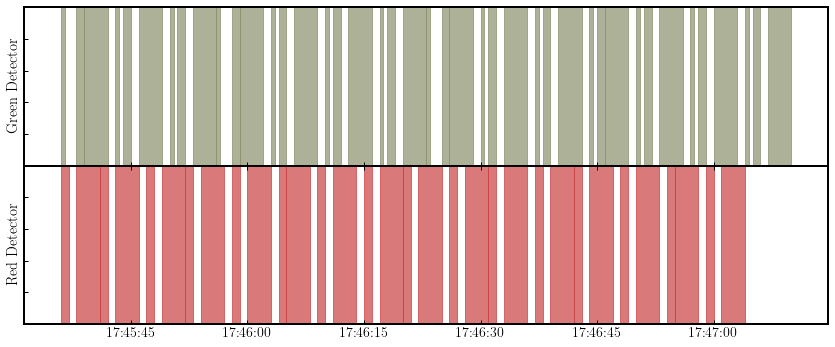

In [11]:
fig = plt.figure(figsize=(12,5),constrained_layout=False)

gs_plot = fig.add_gridspec(nrows=2,ncols=1,hspace=0.,left=0.05,right=0.98,bottom=0.1,top=0.98)
ax1 = fig.add_subplot(gs_plot[0])
ax2 = fig.add_subplot(gs_plot[1])

ax2.get_shared_x_axes().join(ax1,ax2)
ax1.set_ylabel("Green Detector",fontsize=15)
ax2.set_ylabel("Red Detector",fontsize=15)

for ii, green_row_ in totality_green_df_ext.iterrows():
    date_obs = green_row_["date-obs"]
    exptime = np.float64(green_row_["exptime"])

    obs_end = date_obs + timedelta(seconds=exptime)
    ax1.axvspan(date_obs, obs_end,color="#89916B",alpha=0.7)

for ii, green_row_ in totality_red_df_ext.iterrows():
    date_obs = green_row_["date-obs"]
    exptime = np.float64(green_row_["exptime"])

    obs_end = date_obs + timedelta(seconds=exptime)
    ax2.axvspan(date_obs, obs_end,color="#CB4042",alpha=0.7)



ax1.tick_params(labelbottom=False,direction="in",labelleft=False)
ax2.tick_params(top=True,direction="in",labelleft=False,labelsize=14)

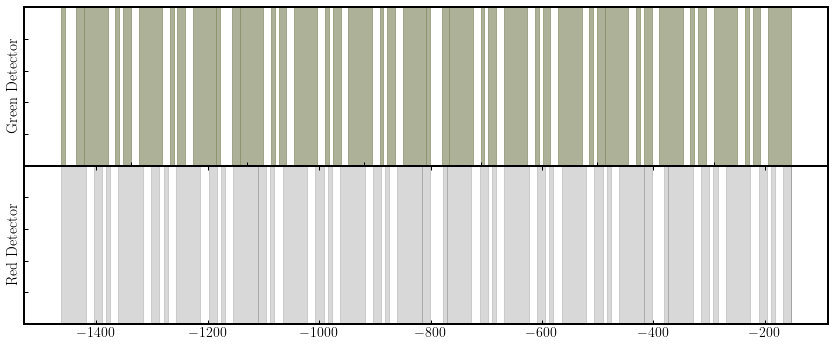

In [12]:
fig = plt.figure(figsize=(12,5),constrained_layout=False)

gs_plot = fig.add_gridspec(nrows=2,ncols=1,hspace=0.,left=0.05,right=0.98,bottom=0.1,top=0.98)
ax1 = fig.add_subplot(gs_plot[0])
ax2 = fig.add_subplot(gs_plot[1])

ax1.set_ylabel("Green Detector",fontsize=15)
ax2.set_ylabel("Red Detector",fontsize=15)

for ii, green_row_ in totality_green_df_ext.iterrows():
    date_obs = green_row_["date-obs"]
    exptime = np.float64(green_row_["exptime"])

    obs_end = date_obs + timedelta(seconds=exptime)
    ax1.axvspan(date_obs, obs_end,color="#89916B",alpha=0.7)

for ii, green_row_ in totality_green_df_ext.iterrows():
    date_obs = green_row_["date-obs"]
    exptime = np.float64(green_row_["exptime"])

    starttime = datetime(2017,8,21,17,45,36)
    time_difference = date_obs - datetime(2017,8,21,17,45,36)
    startindex = time_difference.total_seconds() 
    endindex = startindex + exptime
    
    if startindex < 5:
        slit_xshift_start = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_start = sun_x_fitpoly(startindex) - slit_pos

    if endindex < 5:
        slit_xshift_end = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_end = sun_x_fitpoly(endindex) - slit_pos

    if startindex == endindex:
        pass
    else:
        slit_start_x = - slit_xshift_start/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_start_y = slit_xshift_start/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_x = - slit_xshift_end/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_y = slit_xshift_end/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

        # ax1.fill_between(fill_between_x, fill_between_y_bottom, fill_between_y_top, alpha=0.3,color="grey")
        ax2.axvspan(- slit_xshift_end/pixel_ratio_to_arcsec, - slit_xshift_start/pixel_ratio_to_arcsec,alpha=0.3,color="grey" )


ax1.tick_params(labelbottom=False,direction="in",labelleft=False)
ax2.tick_params(top=True,direction="in",labelleft=False,labelsize=14)

In [13]:
def straight_line_slope(x,x0,y0,k):
    return k*(x - x0) + y0

In [14]:
totality_green_df_ext[["exptime","file"]]

,exptime,file
0,1.0,TotalitySequenceGreen_22708(2)_l1.fit
1,3.0,TotalitySequenceGreen_22708(3)_l1.fit
2,0.5,TotalitySequenceGreen_22708_l1.fit
3,1.0,TotalitySequenceGreen_22709(2)_l1.fit
4,3.0,TotalitySequenceGreen_22709(3)_l1.fit
5,0.5,TotalitySequenceGreen_22709_l1.fit
6,1.0,TotalitySequenceGreen_22710(2)_l1.fit
7,3.0,TotalitySequenceGreen_22710(3)_l1.fit
8,0.5,TotalitySequenceGreen_22710_l1.fit
9,1.0,TotalitySequenceGreen_22711(2)_l1.fit


In [15]:
green_frame_example = CCDData.read(os.path.join(green_path,"TotalitySequenceGreen_22717(3)_l1.fit"),hdu=0,unit="adu")
green_frame_wavelength = CCDData.read(os.path.join(green_path,"TotalitySequenceGreen_22717(3)_l1.fit"),hdu=2,unit="adu").data

In [16]:
green_frame_example.data.shape

(350, 1310)

In [17]:
def order63to62(x):
    return x*63./62.

def order62to63(x):
    return x*62./63.

def order63to61(x):
    return x*63./61.

def order61to63(x):
    return x*61./63.

INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.
INFO:sunpy:Missing metadata for solar radius: assuming the standard radius of the photosphere.


INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]
INFO: Missing metadata for solar radius: assuming the standard radius of the photosphere. [sunpy.map.mapbase]


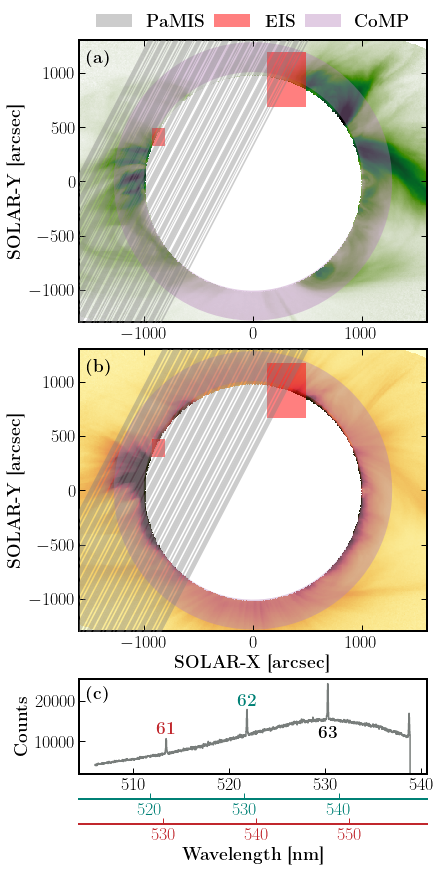

In [18]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6,12),constrained_layout=True,gridspec_kw={"height_ratios":[3,3,1]})

im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.1,vmax=1.3,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True)

im2 = ax2.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                    cmap=cmcm.lajolla,shading="auto",rasterized=True)

ax1_xlim = ax1.get_xlim()
ax1_ylim = ax1.get_ylim()
ax2_xlim = ax2.get_xlim()
ax2_ylim = ax2.get_ylim()


starttime = datetime(2017,8,21,17,45,36)
for ii, green_row_ in totality_green_df_ext.iterrows():
    date_obs = green_row_["date-obs"]
    exptime = np.float64(green_row_["exptime"])

    time_difference = date_obs - datetime(2017,8,21,17,45,36)
    startindex = time_difference.total_seconds() 
    endindex = startindex + exptime
    
    if startindex < 5:
        slit_xshift_start = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_start = sun_x_fitpoly(startindex) - slit_pos

    if endindex < 5:
        slit_xshift_end = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_end = sun_x_fitpoly(endindex) - slit_pos

    if startindex == endindex:
        pass
    else:
        slit_start_x = - slit_xshift_start/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_start_y = slit_xshift_start/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_x = - slit_xshift_end/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_y = slit_xshift_end/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

        slit_center_x = (slit_start_x + slit_end_x)/2.
        slit_center_y = (slit_start_y + slit_end_y)/2.

        slit_plot_interval = (slit_end_y - slit_center_y)/(np.sin(np.deg2rad(np.abs(rotate_angle_context)))**2)
        slit_plot_top_y = slit_center_y + slit_plot_interval
        slit_plot_bottom_y = slit_center_y - slit_plot_interval

        fill_between_x = np.linspace(1000,-2500)
        fill_between_y_top = straight_line_slope(fill_between_x, slit_center_x, slit_plot_top_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))
        fill_between_y_bottom = straight_line_slope(fill_between_x, slit_center_x, slit_plot_bottom_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))

        ax1.fill_between(fill_between_x, fill_between_y_bottom, fill_between_y_top, alpha=0.4,color="grey",
                         linewidth=0,label=r"\textbf{PaMIS}",zorder=3)

plot_eis_fov(ax1,eis_atlas_30_fexiv_intmap_shifted,color="red",alpha=0.5,
             label=r"\textbf{EIS}")
plot_eis_fov(ax1,eis_ch_fexiv_intmap_shifted,color="red",alpha=0.5,
             label=r"\textbf{EIS}")
plot_comp_fov(ax1,zorder=1,alpha=0.4,color="#B481BB",label=r"\textbf{CoMP}")

plot_comp_fov(ax2,zorder=1,color="#B481BB",alpha=0.4)
for ii, red_row_ in totality_red_df_ext.iterrows():
    date_obs = red_row_["date-obs"]
    exptime = np.float64(red_row_["exptime"])

    time_difference = date_obs - datetime(2017,8,21,17,45,36+2) 
    startindex = time_difference.total_seconds() 
    endindex = startindex + exptime
    
    if startindex < 5:
        slit_xshift_start = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_start = sun_x_fitpoly(startindex) - slit_pos

    if endindex < 5:
        slit_xshift_end = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_end = sun_x_fitpoly(endindex) - slit_pos

    if startindex == endindex:
        pass
    else:
        slit_start_x = - slit_xshift_start/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_start_y = slit_xshift_start/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_x = - slit_xshift_end/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_y = slit_xshift_end/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

        slit_center_x = (slit_start_x + slit_end_x)/2.
        slit_center_y = (slit_start_y + slit_end_y)/2.

        slit_plot_interval = (slit_end_y - slit_center_y)/(np.sin(np.deg2rad(np.abs(rotate_angle_context)))**2)
        slit_plot_top_y = slit_center_y + slit_plot_interval
        slit_plot_bottom_y = slit_center_y - slit_plot_interval

        fill_between_x = np.linspace(1000,-2500)
        fill_between_y_top = straight_line_slope(fill_between_x, slit_center_x, slit_plot_top_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))
        fill_between_y_bottom = straight_line_slope(fill_between_x, slit_center_x, slit_plot_bottom_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))

        ax2.fill_between(fill_between_x, fill_between_y_bottom, fill_between_y_top, alpha=0.4,color="grey",
                         linewidth=0,label=r"\textbf{PaMIS}",zorder=3)
        
    
plot_eis_fov(ax2,eis_atlas_30_fex_intmap_shifted,color="red",alpha=0.5,
             label=r"\textbf{EIS}")
plot_eis_fov(ax2,eis_ch_fex_intmap_shifted,color="red",alpha=0.5,
             label=r"\textbf{EIS}")

 
xlim_zoomin = (-1600,1600)
ylim_zoomin = (-1300,1300)

handles, labels = ax1.get_legend_handles_labels()
temp_dict = {k:v for k,v in zip(labels, handles)}
ax1.legend(temp_dict.values(), temp_dict.keys(),fontsize=18,frameon=False,
           bbox_to_anchor=(0,1.05,1,0.1),mode="expand",ncol=3)

ax3.step(green_frame_wavelength/63./10., green_frame_example.data[170,:],
         where="mid",color="#787D7B")


ax1.text(0.02,0.97,r"\textbf{(a)}",fontsize=18,ha="left",va="top",
         transform=ax1.transAxes)
ax2.text(0.02,0.97,r"\textbf{(b)}",fontsize=18,ha="left",va="top",
         transform=ax2.transAxes)
ax3.text(0.02,0.93,r"\textbf{(c)}",fontsize=18,ha="left",va="top",
         transform=ax3.transAxes)

for ax_ in (ax1,ax2):
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=18,direction="in",top=True,right=True)
    ax_.tick_params(which="major",length=6)
    ax_.set_ylabel(r"\textbf{SOLAR-Y [arcsec]}",fontsize=18)

ax1.set_xlim(xlim_zoomin)
ax1.set_ylim(ylim_zoomin)
ax2.set_xlim(xlim_zoomin)
ax2.set_ylim(ylim_zoomin)

ax2.set_xlabel(r"\textbf{SOLAR-X [arcsec]}",fontsize=18)

ax3.set_ylim(bottom=2e3)
ax3_62 = ax3.secondary_xaxis('bottom', functions=(order63to62, order62to63))
ax3_62.spines['bottom'].set_position(('outward', 25)) 
ax3_61 = ax3.secondary_xaxis('bottom', functions=(order63to61, order61to63))
ax3_61.spines['bottom'].set_position(('outward', 50)) 

ax3.text(530.3*61/63,1.3e4,r"\textbf{61}",fontsize=18,color="#C1272D",va="center",ha="center")
ax3.text(530.3*62/63,2e4,r"\textbf{62}",fontsize=18,color="#008176",va="center",ha="center")
ax3.text(530.3,1.2e4,r"\textbf{63}",fontsize=18,va="center",ha="center")

ax3_61.set_xlabel(r"\textbf{Wavelength [nm]}",fontsize=18)


for ax_ in (ax3,ax3_62,ax3_61):
    ax_.tick_params(labelsize=18,direction="in",which="major",length=6)

ax3_62.tick_params(colors="#008176")
ax3_62.spines['bottom'].set_color("#008176")
ax3_61.tick_params(colors="#C1272D")
ax3_61.spines['bottom'].set_color("#C1272D")


ax3.set_ylabel(r"\textbf{Counts}",fontsize=18)

plt.savefig("../../figs/ms/obs_summary_all.pdf",dpi=300,format="pdf",
            bbox_inches="tight")


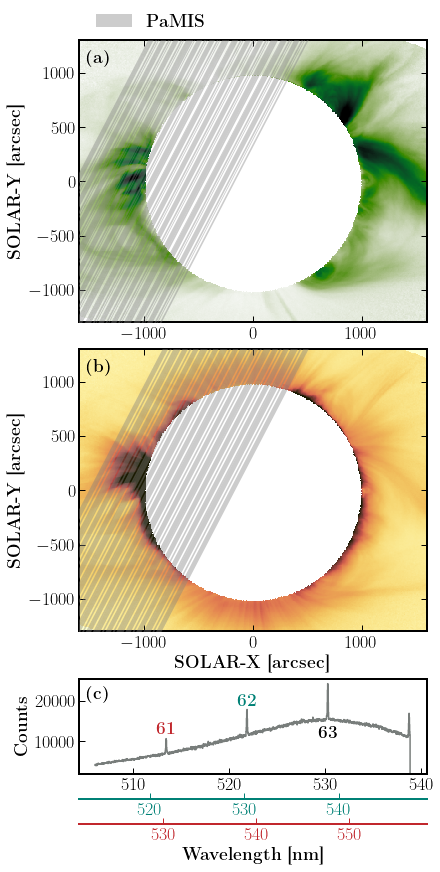

In [19]:
fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(6,12),constrained_layout=True,gridspec_kw={"height_ratios":[3,3,1]})

im1 = ax1.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXIV_line_cont_image_rot_scipy,vmin=0.1,vmax=1.3,
                    cmap=cmr.jungle_r,shading="auto",rasterized=True)

im2 = ax2.pcolormesh(img_xarcsec_array,img_yarcsec_array,FeXI_line_cont_image_rot_scipy,vmin=1,vmax=4,
                    cmap=cmcm.lajolla,shading="auto",rasterized=True)

ax1_xlim = ax1.get_xlim()
ax1_ylim = ax1.get_ylim()
ax2_xlim = ax2.get_xlim()
ax2_ylim = ax2.get_ylim()


starttime = datetime(2017,8,21,17,45,36)
for ii, green_row_ in totality_green_df_ext.iterrows():
    date_obs = green_row_["date-obs"]
    exptime = np.float64(green_row_["exptime"])

    time_difference = date_obs - datetime(2017,8,21,17,45,36)
    startindex = time_difference.total_seconds() 
    endindex = startindex + exptime
    
    if startindex < 5:
        slit_xshift_start = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_start = sun_x_fitpoly(startindex) - slit_pos

    if endindex < 5:
        slit_xshift_end = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_end = sun_x_fitpoly(endindex) - slit_pos

    if startindex == endindex:
        pass
    else:
        slit_start_x = - slit_xshift_start/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_start_y = slit_xshift_start/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_x = - slit_xshift_end/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_y = slit_xshift_end/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

        slit_center_x = (slit_start_x + slit_end_x)/2.
        slit_center_y = (slit_start_y + slit_end_y)/2.

        slit_plot_interval = (slit_end_y - slit_center_y)/(np.sin(np.deg2rad(np.abs(rotate_angle_context)))**2)
        slit_plot_top_y = slit_center_y + slit_plot_interval
        slit_plot_bottom_y = slit_center_y - slit_plot_interval

        fill_between_x = np.linspace(1000,-2500)
        fill_between_y_top = straight_line_slope(fill_between_x, slit_center_x, slit_plot_top_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))
        fill_between_y_bottom = straight_line_slope(fill_between_x, slit_center_x, slit_plot_bottom_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))

        ax1.fill_between(fill_between_x, fill_between_y_bottom, fill_between_y_top, alpha=0.4,color="grey",
                         linewidth=0,label=r"\textbf{PaMIS}",zorder=3)

# plot_eis_fov(ax1,eis_atlas_30_fexiv_intmap_shifted,color="red",alpha=0.5,
#              label=r"\textbf{EIS}")
# plot_eis_fov(ax1,eis_ch_fexiv_intmap_shifted,color="red",alpha=0.5,
#              label=r"\textbf{EIS}")
# plot_comp_fov(ax1,zorder=1,alpha=0.4,color="#B481BB",label=r"\textbf{CoMP}")

# plot_comp_fov(ax2,zorder=1,color="#B481BB",alpha=0.4)
for ii, red_row_ in totality_red_df_ext.iterrows():
    date_obs = red_row_["date-obs"]
    exptime = np.float64(red_row_["exptime"])

    time_difference = date_obs - datetime(2017,8,21,17,45,36+2) 
    startindex = time_difference.total_seconds() 
    endindex = startindex + exptime
    
    if startindex < 5:
        slit_xshift_start = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_start = sun_x_fitpoly(startindex) - slit_pos

    if endindex < 5:
        slit_xshift_end = sun_x_fitpoly(5) - slit_pos
    else:
        slit_xshift_end = sun_x_fitpoly(endindex) - slit_pos

    if startindex == endindex:
        pass
    else:
        slit_start_x = - slit_xshift_start/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_start_y = slit_xshift_start/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_x = - slit_xshift_end/pixel_ratio_to_arcsec*np.cos(np.deg2rad(np.abs(rotate_angle_context)))
        slit_end_y = slit_xshift_end/pixel_ratio_to_arcsec*np.sin(np.deg2rad(np.abs(rotate_angle_context)))

        slit_center_x = (slit_start_x + slit_end_x)/2.
        slit_center_y = (slit_start_y + slit_end_y)/2.

        slit_plot_interval = (slit_end_y - slit_center_y)/(np.sin(np.deg2rad(np.abs(rotate_angle_context)))**2)
        slit_plot_top_y = slit_center_y + slit_plot_interval
        slit_plot_bottom_y = slit_center_y - slit_plot_interval

        fill_between_x = np.linspace(1000,-2500)
        fill_between_y_top = straight_line_slope(fill_between_x, slit_center_x, slit_plot_top_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))
        fill_between_y_bottom = straight_line_slope(fill_between_x, slit_center_x, slit_plot_bottom_y, 
                                            1./np.tan(np.deg2rad(np.abs(rotate_angle_context))))

        ax2.fill_between(fill_between_x, fill_between_y_bottom, fill_between_y_top, alpha=0.4,color="grey",
                         linewidth=0,label=r"\textbf{PaMIS}",zorder=3)
        
    
# plot_eis_fov(ax2,eis_atlas_30_fex_intmap_shifted,color="red",alpha=0.5,
#              label=r"\textbf{EIS}")
# plot_eis_fov(ax2,eis_ch_fex_intmap_shifted,color="red",alpha=0.5,
#              label=r"\textbf{EIS}")

 
xlim_zoomin = (-1600,1600)
ylim_zoomin = (-1300,1300)

handles, labels = ax1.get_legend_handles_labels()
temp_dict = {k:v for k,v in zip(labels, handles)}
ax1.legend(temp_dict.values(), temp_dict.keys(),fontsize=18,frameon=False,
           bbox_to_anchor=(0,1.05,1,0.1),mode="expand",ncol=3)

ax3.step(green_frame_wavelength/63./10., green_frame_example.data[170,:],
         where="mid",color="#787D7B")


ax1.text(0.02,0.97,r"\textbf{(a)}",fontsize=18,ha="left",va="top",
         transform=ax1.transAxes)
ax2.text(0.02,0.97,r"\textbf{(b)}",fontsize=18,ha="left",va="top",
         transform=ax2.transAxes)
ax3.text(0.02,0.93,r"\textbf{(c)}",fontsize=18,ha="left",va="top",
         transform=ax3.transAxes)

for ax_ in (ax1,ax2):
    ax_.set_aspect(1)
    ax_.tick_params(labelsize=18,direction="in",top=True,right=True)
    ax_.tick_params(which="major",length=6)
    ax_.set_ylabel(r"\textbf{SOLAR-Y [arcsec]}",fontsize=18)

ax1.set_xlim(xlim_zoomin)
ax1.set_ylim(ylim_zoomin)
ax2.set_xlim(xlim_zoomin)
ax2.set_ylim(ylim_zoomin)

ax2.set_xlabel(r"\textbf{SOLAR-X [arcsec]}",fontsize=18)

ax3.set_ylim(bottom=2e3)
ax3_62 = ax3.secondary_xaxis('bottom', functions=(order63to62, order62to63))
ax3_62.spines['bottom'].set_position(('outward', 25)) 
ax3_61 = ax3.secondary_xaxis('bottom', functions=(order63to61, order61to63))
ax3_61.spines['bottom'].set_position(('outward', 50)) 

ax3.text(530.3*61/63,1.3e4,r"\textbf{61}",fontsize=18,color="#C1272D",va="center",ha="center")
ax3.text(530.3*62/63,2e4,r"\textbf{62}",fontsize=18,color="#008176",va="center",ha="center")
ax3.text(530.3,1.2e4,r"\textbf{63}",fontsize=18,va="center",ha="center")

ax3_61.set_xlabel(r"\textbf{Wavelength [nm]}",fontsize=18)


for ax_ in (ax3,ax3_62,ax3_61):
    ax_.tick_params(labelsize=18,direction="in",which="major",length=6)

ax3_62.tick_params(colors="#008176")
ax3_62.spines['bottom'].set_color("#008176")
ax3_61.tick_params(colors="#C1272D")
ax3_61.spines['bottom'].set_color("#C1272D")


ax3.set_ylabel(r"\textbf{Counts}",fontsize=18)

plt.savefig("../../figs/ms/obs_summary_PaMIS.pdf",dpi=300,format="pdf",
            bbox_inches="tight")
